In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = trp
band = 3b
commitnumber = f17e0b2
conc = 0.0008
dv = 0.001
klin = 0
molecule = co2
ng_adju = [0, 0]
ng_refs = [5, 2]
nv = 1000
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 2
option_wgt_k = 1
ref_pts = [(1, 250), (10, 250)]
tsfc = 300
w_diffuse = [(1.66, 1.66, 1.66, 1.66, 1.66), (1.66, 1.66)]
wgt = [(0, 0.6, 0.5, 0.7, 0.8), (0.8, 0.7)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

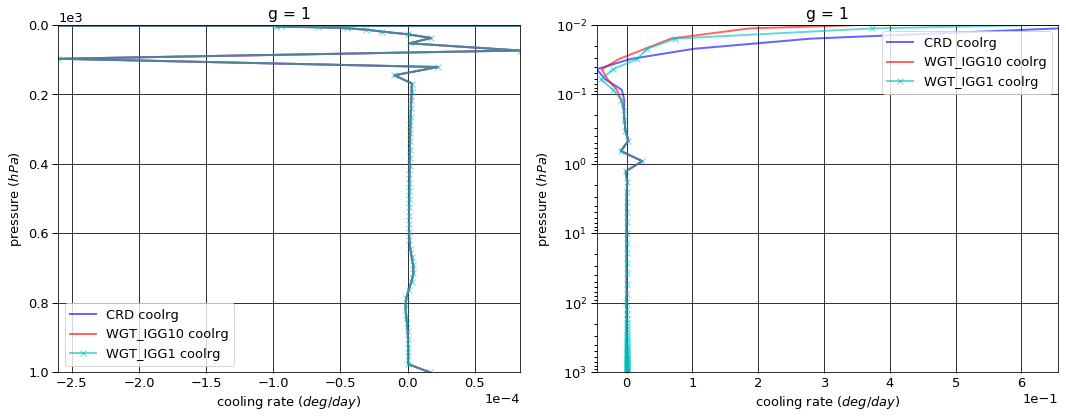

# Figure: cooling rate g-group 2

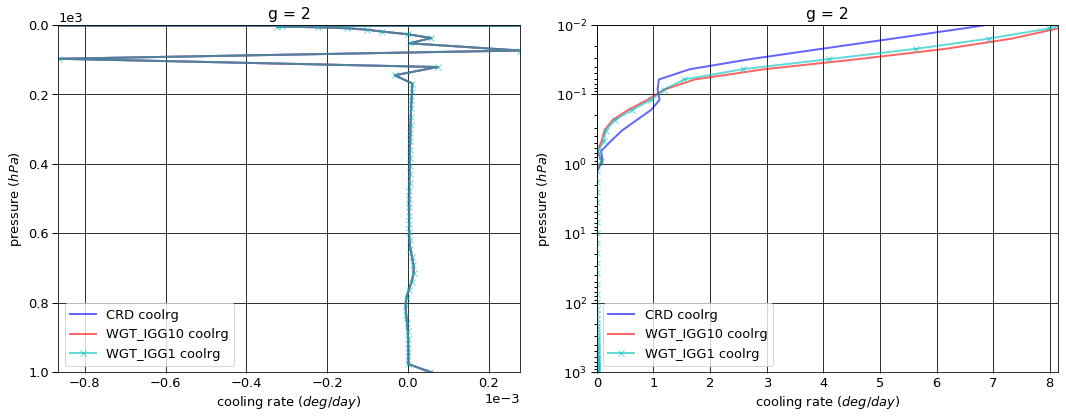

# Figure: cooling rate g-group 3

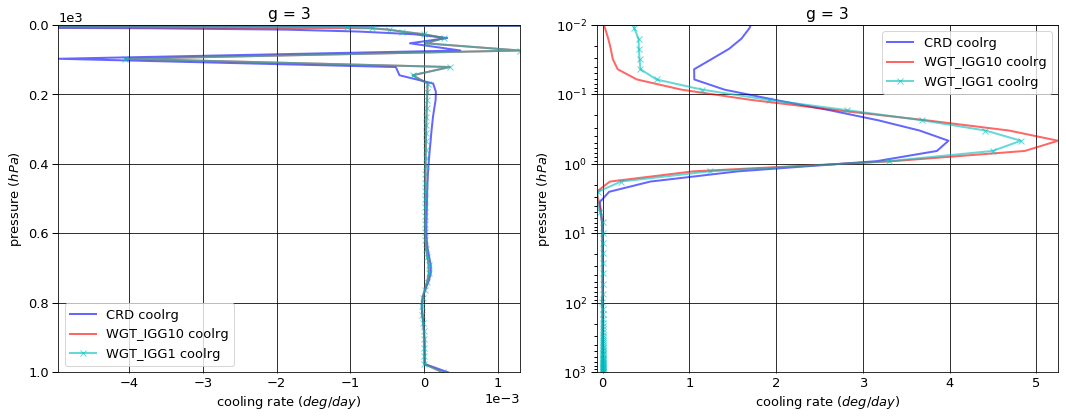

# Figure: cooling rate g-group 4

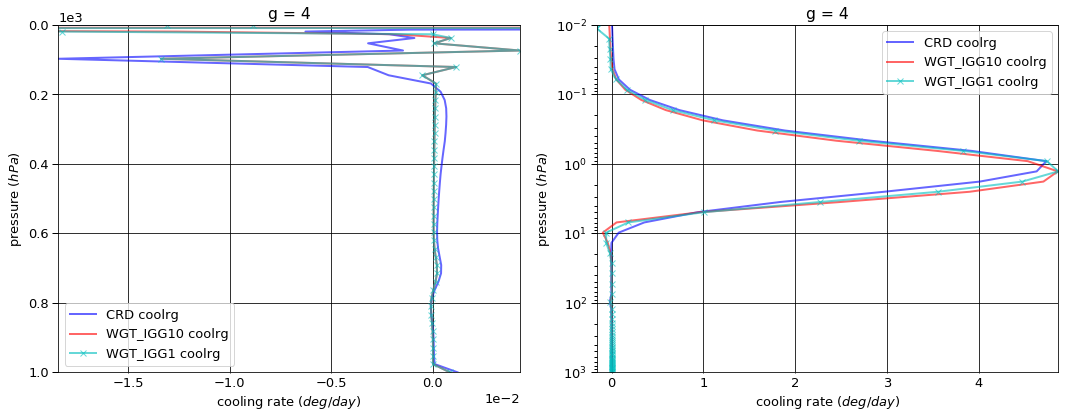

# Figure: cooling rate g-group 5

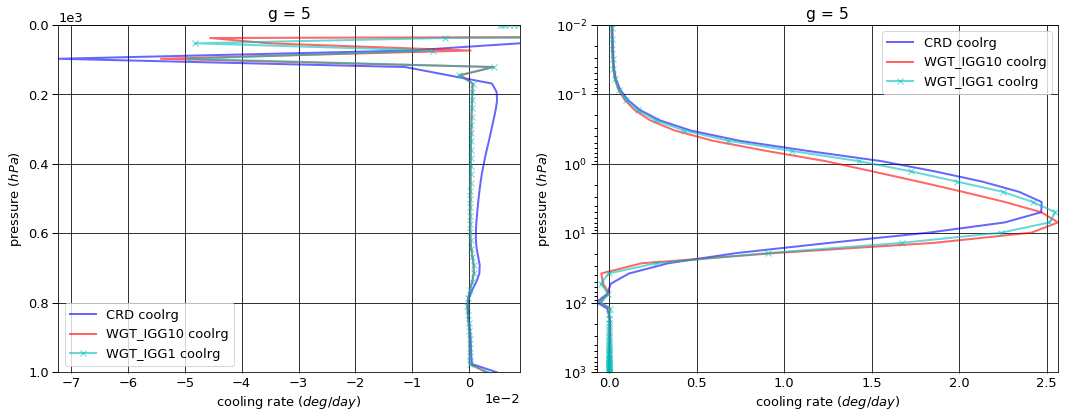

# Figure: cooling rate g-group 6

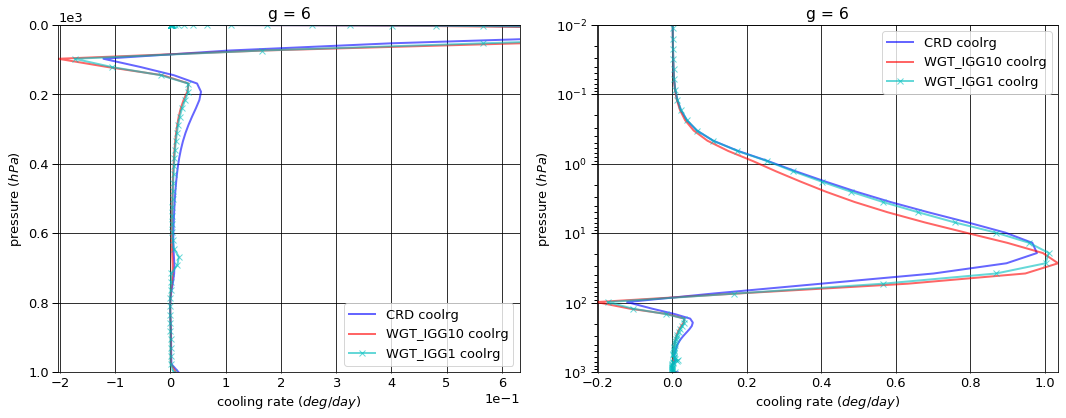

# Figure: cooling rate g-group 7

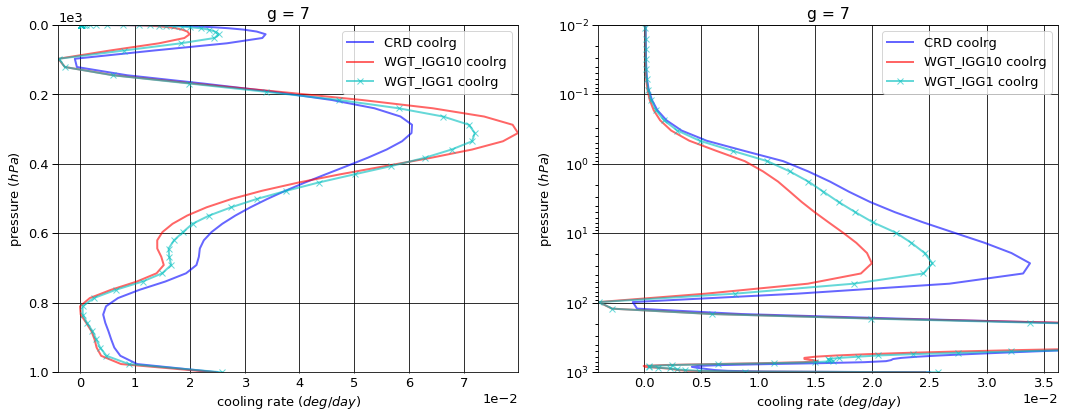

# Figure: cooling rate g-group total

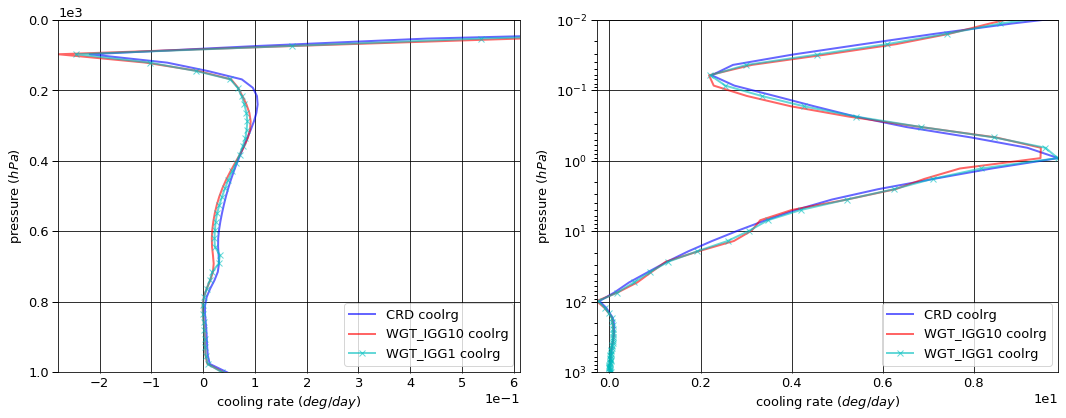

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.015230   0.000000 -0.015230
  1013.0   76     -0.060398   0.060352 -0.000046
2 0.0      1      -0.066125   0.000000 -0.066125
  1013.0   76     -0.200535   0.200368 -0.000167
3 0.0      1      -0.513796   0.000000 -0.513796
  1013.0   76     -0.941872   0.940949 -0.000923
4 0.0      1      -1.712507   0.000000 -1.712507
  1013.0   76     -3.111329   3.107688 -0.003641
5 0.0      1      -4.492996   0.000000 -4.492996
  1013.0   76    -11.461662  11.446654 -0.015007
6 0.0      1      -6.287790   0.000000 -6.287790
  1013.0   76    -22.261089  22.216894 -0.044194
7 0.0      1      -3.295808   0.000000 -3.295808
  1013.0   76     -9.030664   8.909697 -0.120968


WGT_IGG10


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.015274   0.000000 -0.015274
  1013.0   76     -0.060398   0.060352 -0.000046
2 0.0      1      -0.058569   0.000000 -0.058569
  1013.0   76     -0.200535   0.200383 -0.000152
3 0.0      1      -0.508905   0.000000 -0.508905
  1013.0   76     -0.941872   0.941160 -0.000713
4 0.0      1      -1.788134   0.000000 -1.788134
  1013.0   76     -3.111329   3.108975 -0.002355
5 0.0      1      -4.638323   0.000000 -4.638323
  1013.0   76    -11.461662  11.452984 -0.008678
6 0.0      1      -6.105490   0.000000 -6.105490
  1013.0   76    -22.261089  22.234554 -0.026534
7 0.0      1      -3.124235   0.000000 -3.124235
  1013.0   76     -9.030664   8.944521 -0.086143


WGT_IGG1


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.015298   0.000000 -0.015298
  1013.0   76     -0.060398   0.060352 -0.000046
2 0.0      1      -0.059197   0.000000 -0.059197
  1013.0   76     -0.200535   0.200383 -0.000152
3 0.0      1      -0.506924   0.000000 -0.506924
  1013.0   76     -0.941872   0.941160 -0.000713
4 0.0      1      -1.776212   0.000000 -1.776212
  1013.0   76     -3.111329   3.108975 -0.002355
5 0.0      1      -4.640494   0.000000 -4.640494
  1013.0   76    -11.461662  11.452984 -0.008678
6 0.0      1      -6.125660   0.000000 -6.125660
  1013.0   76    -22.261089  22.244203 -0.016885
7 0.0      1      -3.182276   0.000000 -3.182276
  1013.0   76     -9.030664   8.932999 -0.097666


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1     -4.400700e-05  0.000000 -0.000044
  1013.0   76     0.000000e+00  0.000000  0.000000
2 0.0      1      7.555071e-03  0.000000  0.007555
  1013.0   76     0.000000e+00  0.000015  0.000015
3 0.0      1      4.891070e-03  0.000000  0.004891
  1013.0   76     0.000000e+00  0.000211  0.000211
4 0.0      1     -7.562660e-02  0.000000 -0.075627
  1013.0   76     0.000000e+00  0.001286  0.001286
5 0.0      1     -1.453264e-01  0.000000 -0.145326
  1013.0   76    -1.776357e-15  0.006330  0.006329
6 0.0      1      1.823007e-01  0.000000  0.182301
  1013.0   76     3.552714e-15  0.017660  0.017660
7 0.0      1      1.715728e-01  0.000000  0.171573
  1013.0   76     0.000000e+00  0.034825  0.034825


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1     -6.750500e-05  0.000000 -0.000068
  1013.0   76     0.000000e+00  0.000000  0.000000
2 0.0      1      6.927245e-03  0.000000  0.006927
  1013.0   76     0.000000e+00  0.000015  0.000015
3 0.0      1      6.871520e-03  0.000000  0.006872
  1013.0   76     0.000000e+00  0.000211  0.000211
4 0.0      1     -6.370470e-02  0.000000 -0.063705
  1013.0   76     0.000000e+00  0.001286  0.001286
5 0.0      1     -1.474978e-01  0.000000 -0.147498
  1013.0   76    -1.776357e-15  0.006330  0.006329
6 0.0      1      1.621308e-01  0.000000  0.162131
  1013.0   76     3.552714e-15  0.027309  0.027309
7 0.0      1      1.135322e-01  0.000000  0.113532
  1013.0   76     0.000000e+00  0.023302  0.023302

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer            
1 0.000312    1      101.690940
  1001.112500 75       0.000016
2 0.000312    1       12.663050
  1001.112500 75       0.000060
3 0.000312    1        1.495491
  1001.112500 75       0.000328
4 0.000312    1       -0.051430
  1001.112500 75       0.001230
5 0.000312    1        0.008006
  1001.112500 75       0.004861
6 0.000312    1        0.000604
  1001.112500 75       0.014784
7 0.000312    1        0.000058
  1001.112500 75       0.025007


WGT_IGG10


coolrg
g pressure    layer           
1 0.000312    1      66.687285
  1001.112500 75      0.000016
2 0.000312    1       8.352419
  1001.112500 75      0.000054
3 0.000312    1      -0.329340
  1001.112500 75      0.000255
4 0.000312    1      -0.064559
  1001.112500 75      0.000844
5 0.000312    1       0.006725
  1001.112500 75      0.003110
6 0.000312    1       0.000582
  1001.112500 75      0.009679
7 0.000312    1       0.000041
  1001.112500 75      0.024618


WGT_IGG1


coolrg
g pressure    layer           
1 0.000312    1      68.951101
  1001.112500 75      0.000016
2 0.000312    1      10.137448
  1001.112500 75      0.000054
3 0.000312    1      -0.006454
  1001.112500 75      0.000255
4 0.000312    1      -0.080361
  1001.112500 75      0.000844
5 0.000312    1       0.005325
  1001.112500 75      0.003110
6 0.000312    1       0.000611
  1001.112500 75      0.006052
7 0.000312    1       0.000056
  1001.112500 75      0.025783


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -3.500365e+01
  1001.112500 75    -3.388132e-21
2 0.000312    1     -4.310631e+00
  1001.112500 75    -5.316270e-06
3 0.000312    1     -1.824831e+00
  1001.112500 75    -7.255303e-05
4 0.000312    1     -1.312907e-02
  1001.112500 75    -3.862559e-04
5 0.000312    1     -1.281103e-03
  1001.112500 75    -1.750571e-03
6 0.000312    1     -2.224356e-05
  1001.112500 75    -5.105180e-03
7 0.000312    1     -1.731973e-05
  1001.112500 75    -3.886940e-04


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -3.273984e+01
  1001.112500 75    -3.388132e-21
2 0.000312    1     -2.525602e+00
  1001.112500 75    -5.316270e-06
3 0.000312    1     -1.501945e+00
  1001.112500 75    -7.255303e-05
4 0.000312    1     -2.893062e-02
  1001.112500 75    -3.862559e-04
5 0.000312    1     -2.681405e-03
  1001.112500 75    -1.750571e-03
6 0.000312    1      6.467580e-06
  1001.112500 75    -8.732330e-03
7 0.000312    1     -1.886013e-06
  1001.112500 75     7.762580e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-16.384252,0.000000,-16.384252
1013.0,76,-47.067549,46.882602,-0.184947



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-16.238929,0.000000,-16.238929
1013.0,76,-47.067549,46.942928,-0.124620



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-16.306060,0.000000,-16.306060
1013.0,76,-47.067549,46.941055,-0.126494



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.145323,0.000000,0.145323
1013.0,76,0.000000,0.060327,0.060326



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.078192,0.000000,0.078192
1013.0,76,0.000000,0.058453,0.058453


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,115.806720
1001.112500,75,0.046286



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,74.653153
1001.112500,75,0.038578



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,79.007726
1001.112500,75,0.036115



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-41.153567
1001.112500,75,-0.007709



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-36.798993
1001.112500,75,-0.010171


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.00128,0.001284
2,0.00425,0.004268
3,0.01996,0.020046
4,0.06595,0.066215
5,0.24303,0.243868
6,0.47273,0.473104
7,0.19280,0.191215


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.306538e-17
2,6.987267e-19
3,3.736738e-20
4,1.998379e-21
5,1.068718e-22
6,5.714218e-23
7,3.056582e-24


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.306538e-17,NaN,0.00128,0.001284,0.00128,0.001284,1.0
2,6.987267e-19,0.053479,0.00425,0.004268,0.00553,0.005552,1.0
3,3.736738e-20,0.053479,0.01996,0.020046,0.02549,0.025598,1.0
4,1.998379e-21,0.053479,0.06595,0.066215,0.09144,0.091813,1.0
5,1.068718e-22,0.053479,0.24303,0.243868,0.33447,0.335681,1.0
6,5.714218e-23,0.534680,0.47273,0.473104,0.80720,0.808785,10.0
7,3.056582e-24,0.053491,0.19280,0.191215,1.00000,1.000000,10.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
